# Time-Varying Benefits of Diversification in Cryptocurrency Portfolios

In [273]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
import pickle
import seaborn as sns
import plotly.graph_objects as go
from tqdm import tqdm, tqdm_notebook
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.optimize import minimize


## Data Preprocessing

Helper Functions

In [271]:
# Function to show dataframe structure
def print_dataframe_structure(dataframe):
    print("Index data type: ", dataframe.index.dtype)
    print("Column structure: ", dataframe.columns)
    print("Shape of the DataFrame: ", dataframe.shape)
    print("Number of missing values: ", dataframe.isna().sum().sum())
    print("Dataframe Info: \n")
    dataframe.info()

# Function to save data as a pickle file
def save_data(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

# Function to load data
def load_data(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

Merge Crypto Price Data CSV files

In [150]:
data_path = "Data/Crypto"
csv_files = [f for f in os.listdir(data_path) if f.endswith("-usd-max.csv")]


def merge_csv_files(files, folder):
    data_frames = []

    for file in files:
        # Read CSV file
        file_path = os.path.join(folder, file)
        data_frame = pd.read_csv(file_path)

        # Extract ticker from file name
        ticker = file.split("-")[0]

        # Rename price column to the corresponding ticker
        data_frame = data_frame.rename(columns={"price": ticker})

        # Drop unnecessary columns
        data_frame = data_frame.drop(columns=["market_cap", "total_volume"])

        # Convert "snapped_at" column to datetime format
        data_frame["snapped_at"] = pd.to_datetime(data_frame["snapped_at"])

        # Set "snapped_at" as the index
        data_frame = data_frame.set_index("snapped_at")

        # Append the processed data frame to the list
        data_frames.append(data_frame)

    # Merge all data frames using the index
    merged_data = pd.concat(data_frames, axis=1, join="outer")

    return merged_data

merged_data_frame = merge_csv_files(csv_files, data_path)

Drop values before 2020-01-01 and after 2023-05-01

In [151]:
# Drop rows before 2020-01-01 and after 2023-05-01
filtered_data_frame = merged_data_frame[(merged_data_frame.index >= '2020-01-01') & (merged_data_frame.index <= '2023-05-01')]


# drop columns with not enough data
filtered_data_frame.drop(columns=["shib"], inplace=True)
output_file_filtered = "filtered_data.csv"
filtered_data_frame.to_csv(output_file_filtered)


C:\Users\thoma\AppData\Local\Temp\ipykernel_18340\442662211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_frame.drop(columns=["shib"], inplace=True)


#### US Treasury Yield Data

In [253]:
# Read the CSV file
UST_data_path = "Data/UST_Yield"

def merge_ust_yields(directory_path, start_date='01-01-2020', end_date='05-01-2023'):
    merged_df = pd.DataFrame()

    # Iterate over the files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)

            # Read the CSV file into a dataframe
            df = pd.read_csv(file_path, parse_dates=["Date"])

            # Keep only the "52 WEEKS BANK DISCOUNT" column
            df = df[["Date", "52 WEEKS BANK DISCOUNT"]]

            # Merge the dataframe with the existing merged dataframe
            merged_df = pd.concat([merged_df, df], ignore_index=True)

    # Set "Date" as the index
    merged_df.set_index("Date", inplace=True)

    # Create a new DataFrame that spans the complete date range
    all_dates = pd.date_range(start=start_date, end=merged_df.index.max())
    all_dates_df = pd.DataFrame(index=all_dates)

    # Merge the new DataFrame with the existing DataFrame
    merged_df = pd.merge(all_dates_df, merged_df, how="left", left_index=True, right_index=True)

    # Fill NaN values with the next valid value (backward filling)
    merged_df = merged_df.bfill()

    # Drop rows after end_date
    merged_df = merged_df.loc[:pd.to_datetime(end_date)]

    return merged_df

merged_ust_data = merge_ust_yields(UST_data_path)


In [255]:
# fill weekend values with the next valid value
merged_ust_data.bfill(inplace=True)

# convert to UTC timezone
merged_ust_data.index = merged_ust_data.index.tz_localize('UTC')

# convert from % annual returns to daily returns
merged_ust_data['52 WEEKS BANK DISCOUNT'] = np.exp(merged_ust_data['52 WEEKS BANK DISCOUNT'] / 100 / 365) - 1

# drop first row to match crypto data
merged_ust_data = merged_ust_data.iloc[1:]

In [154]:
filtered_data_frame.shape

(1217, 32)

In [230]:
print_dataframe_structure(merged_ust_data)

Index data type:  datetime64[ns]
Column structure:  Index(['52 WEEKS BANK DISCOUNT'], dtype='object')
Shape of the DataFrame:  (1217, 1)
Number of missing values:  0
Dataframe Info: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1217 entries, 2020-01-01 to 2023-05-01
Freq: D
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   52 WEEKS BANK DISCOUNT  1217 non-null   float64
dtypes: float64(1)
memory usage: 19.0 KB


## Data Exploration

In [155]:
filtered_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1217 entries, 2020-01-01 00:00:00+00:00 to 2023-05-01 00:00:00+00:00
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ada     1217 non-null   float64
 1   ar      1217 non-null   float64
 2   atom    1217 non-null   float64
 3   bat     1217 non-null   float64
 4   bch     1217 non-null   float64
 5   bnb     1217 non-null   float64
 6   btc     1217 non-null   float64
 7   busd    1217 non-null   float64
 8   cro     1217 non-null   float64
 9   dai     1217 non-null   float64
 10  dash    1217 non-null   float64
 11  dgb     1217 non-null   float64
 12  doge    1217 non-null   float64
 13  etc     1217 non-null   float64
 14  eth     1217 non-null   float64
 15  ftm     1217 non-null   float64
 16  kcs     1217 non-null   float64
 17  leo     1217 non-null   float64
 18  link    1217 non-null   float64
 19  mana    1217 non-null   float64
 20  mkr     1217 non-null   fl

In [156]:
filtered_data_frame.head()

,ada,ar,atom,bat,bch,bnb,btc,busd,cro,dai,...,omg,qtum,snx,usdc,usdt,xlm,xmr,xrp,zec,zil
snapped_at,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,0.032912,0.813411,4.219579,0.180870,204.561792,13.716391,7195.153895,1.002401,0.033641,0.981847,...,0.606727,1.609848,1.205578,1.003172,0.999366,0.045042,44.586492,0.192993,27.529298,0.004452
2020-01-02 00:00:00+00:00,0.033362,0.696112,4.381528,0.194672,204.348311,13.685902,7193.754668,1.002661,0.033955,0.972606,...,0.616387,1.599572,1.209918,1.003346,0.999508,0.045311,45.780578,0.192556,28.046206,0.004503
2020-01-03 00:00:00+00:00,0.032618,0.664268,4.098819,0.182523,195.674640,13.007171,6963.853354,1.001653,0.032891,0.978826,...,0.593536,1.532726,1.114260,1.002434,0.999983,0.043735,45.342985,0.187433,27.029583,0.004354
2020-01-04 00:00:00+00:00,0.033967,0.677890,4.227682,0.186174,221.621452,13.603276,7300.346935,1.001195,0.034394,0.987877,...,0.625430,1.624714,1.161237,1.000130,0.998661,0.045609,50.851224,0.192299,28.448989,0.004474
2020-01-05 00:00:00+00:00,0.034298,0.665807,4.253197,0.188094,224.487505,13.794575,7351.377053,1.001829,0.034388,0.970134,...,0.625897,1.638943,1.140031,1.001133,0.999595,0.045703,50.294998,0.192812,29.934325,0.004557


In [157]:
# Check for missing values
filtered_data_frame.isnull().sum()

ada     0
ar      0
atom    0
bat     0
bch     0
bnb     0
btc     0
busd    0
cro     0
dai     0
dash    0
dgb     0
doge    0
etc     0
eth     0
ftm     0
kcs     0
leo     0
link    0
mana    0
mkr     0
mnw     0
omg     0
qtum    0
snx     0
usdc    0
usdt    0
xlm     0
xmr     0
xrp     0
zec     0
zil     0
dtype: int64

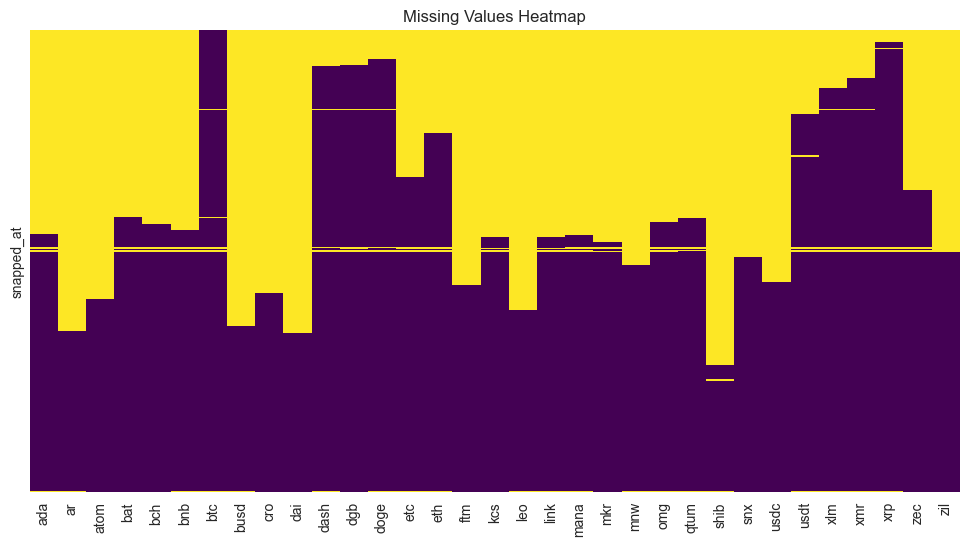

In [158]:
#Viusalize the missing data before cutoff
plt.figure(figsize=(12, 6))
sns.heatmap(merged_data_frame.isna(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

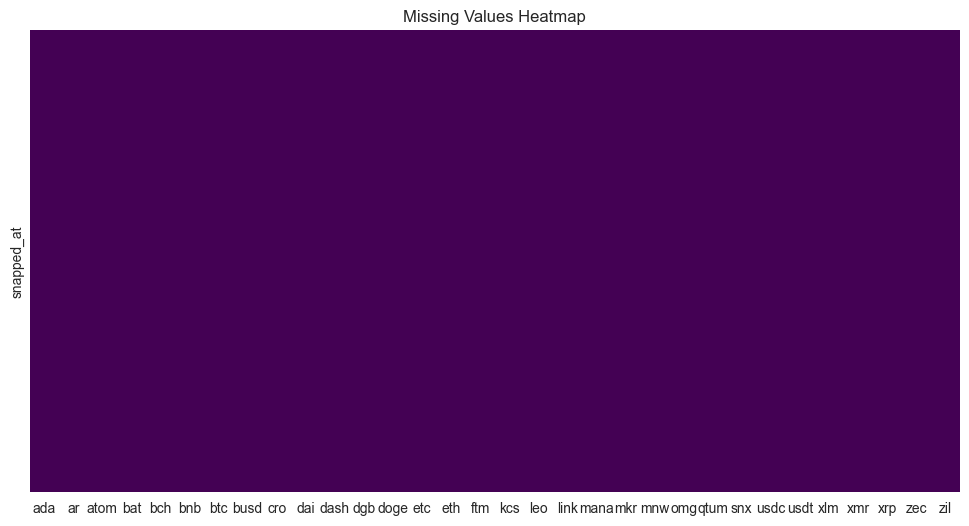

In [159]:
#Viusalize the missing data after cutoff
plt.figure(figsize=(12, 6))
sns.heatmap(filtered_data_frame.isna(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [160]:
filtered_data_frame.columns

Index(['ada', 'ar', 'atom', 'bat', 'bch', 'bnb', 'btc', 'busd', 'cro', 'dai',
       'dash', 'dgb', 'doge', 'etc', 'eth', 'ftm', 'kcs', 'leo', 'link',
       'mana', 'mkr', 'mnw', 'omg', 'qtum', 'snx', 'usdc', 'usdt', 'xlm',
       'xmr', 'xrp', 'zec', 'zil'],
      dtype='object')

Plot Risk-free Rate of Return

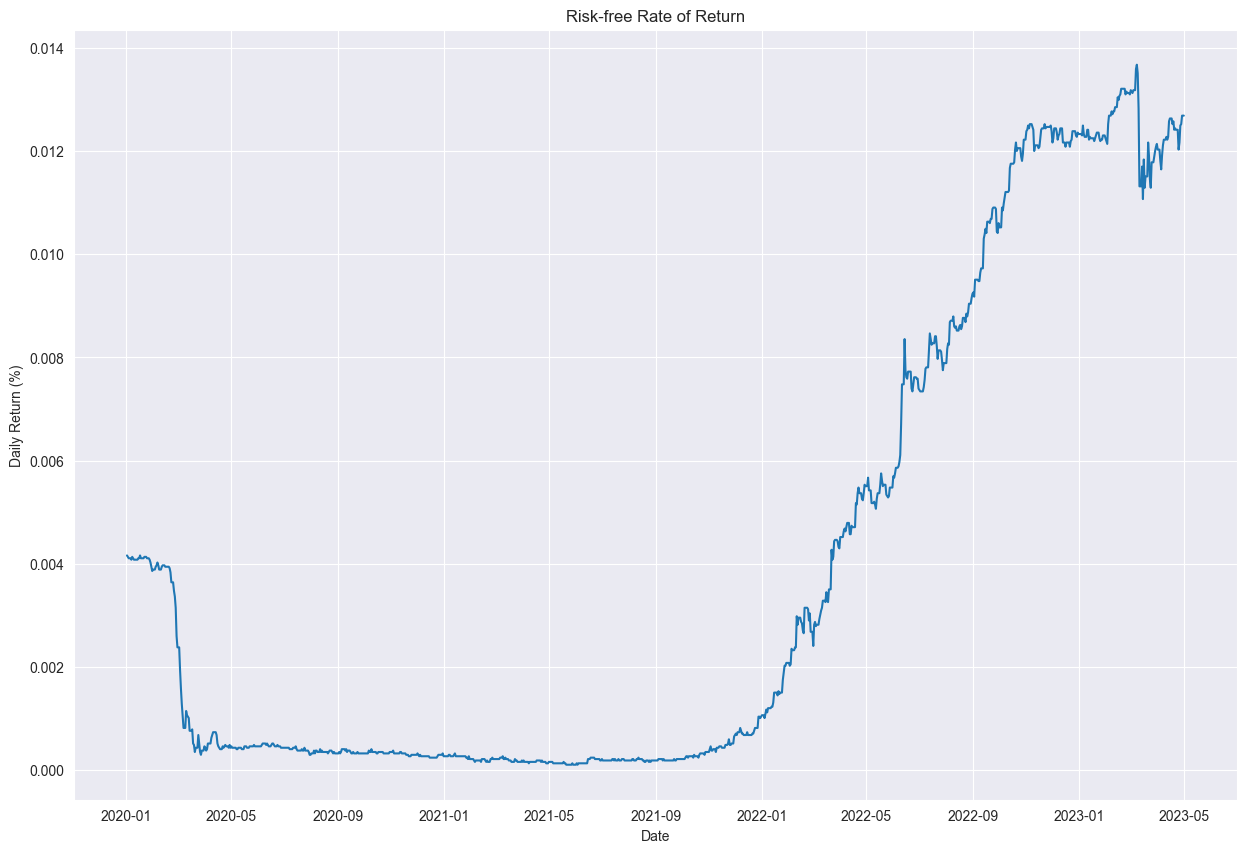

In [266]:
# Plot the prices on the same chart
plt.figure(figsize=(15,10))
plt.plot(merged_ust_data*100)
plt.title('Risk-free Rate of Return')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.show()


In [210]:
# Calculate daily returns
daily_returns = filtered_data_frame.pct_change().dropna()
daily_returns

,ada,ar,atom,bat,bch,bnb,btc,busd,cro,dai,...,omg,qtum,snx,usdc,usdt,xlm,xmr,xrp,zec,zil
snapped_at,,,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,0.013675,-0.144206,0.038380,0.076306,-0.001044,-0.002223,-0.000194,0.000259,0.009345,-0.009412,...,0.015922,-0.006383,0.003600,0.000173,0.000141,0.005971,0.026781,-0.002268,0.018777,0.011438
2020-01-03 00:00:00+00:00,-0.022305,-0.045746,-0.064523,-0.062406,-0.042446,-0.049594,-0.031958,-0.001005,-0.031330,0.006396,...,-0.037073,-0.041790,-0.079061,-0.000910,0.000476,-0.034779,-0.009559,-0.026601,-0.036248,-0.033009
2020-01-04 00:00:00+00:00,0.041374,0.020507,0.031439,0.020000,0.132602,0.045829,0.048320,-0.000458,0.045687,0.009247,...,0.053736,0.060016,0.042160,-0.002298,-0.001322,0.042852,0.121479,0.025960,0.052513,0.027649
2020-01-05 00:00:00+00:00,0.009743,-0.017824,0.006035,0.010313,0.012932,0.014063,0.006990,0.000634,-0.000157,-0.017961,...,0.000746,0.008758,-0.018261,0.001003,0.000935,0.002055,-0.010938,0.002665,0.052211,0.018342
2020-01-06 00:00:00+00:00,0.003751,-0.012317,-0.012698,-0.007883,-0.008120,0.015353,-0.000191,-0.001682,0.000536,0.011305,...,0.013789,-0.008135,-0.011628,-0.000632,-0.000522,-0.007782,0.065704,0.005207,0.025485,0.004308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-27 00:00:00+00:00,0.015734,-0.025982,-0.015787,-0.013336,-0.023204,-0.025536,0.000034,-0.001756,0.034758,-0.000967,...,-0.061759,-0.016862,-0.028819,-0.001343,-0.001175,-0.016423,-0.020904,-0.017753,-0.026928,-0.037488
2023-04-28 00:00:00+00:00,0.022472,0.025053,0.058870,0.026342,-0.002628,0.003261,0.039903,0.001738,0.045679,0.000225,...,0.008514,0.009744,0.020443,0.000935,0.001054,0.009920,-0.017357,0.011601,0.045297,0.004476
2023-04-29 00:00:00+00:00,-0.012406,-0.003749,0.015534,-0.008551,0.007465,-0.021221,-0.004868,-0.000019,0.046439,-0.000192,...,-0.028983,-0.010603,-0.004275,-0.000527,-0.000556,0.003841,-0.003946,0.027956,-0.009491,-0.011285


In [213]:
percentage_returns = daily_returns * 100
percentage_returns.describe()

,ada,ar,atom,bat,bch,bnb,btc,busd,cro,dai,...,omg,qtum,snx,usdc,usdt,xlm,xmr,xrp,zec,zil
count,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,...,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000
mean,0.360346,0.542980,0.305861,0.215675,0.108514,0.410505,0.184687,0.000687,0.220176,0.002359,...,0.304150,0.257062,0.351555,0.000200,0.000546,0.217469,0.231768,0.253452,0.210560,0.420946
std,5.576147,8.688671,6.635857,6.196608,5.538682,5.507264,3.674517,0.402658,5.606930,0.419260,...,7.342107,6.478799,7.714300,0.292383,0.276419,5.737559,4.990514,6.071847,6.015052,7.585544
min,-40.809099,-39.148727,-46.242568,-44.822767,-44.002894,-42.823911,-35.190269,-6.288085,-39.967515,-3.437441,...,-44.732839,-45.239698,-46.152446,-2.808848,-1.953472,-35.555213,-40.070133,-42.278951,-40.557772,-44.570592
25%,-2.585930,-4.037479,-3.128212,-2.719021,-2.339841,-1.757076,-1.436672,-0.121998,-2.213268,-0.148004,...,-3.179529,-2.683828,-4.271884,-0.116780,-0.103977,-2.447138,-2.090550,-2.217568,-2.740861,-3.186445
50%,0.121440,-0.461618,0.154981,0.006548,0.177819,0.234955,0.113856,0.001037,0.272404,0.008244,...,0.119275,0.346653,-0.079553,0.005133,0.002714,0.178093,0.348668,0.081739,0.241111,0.212809
75%,2.822609,4.065259,3.499954,3.091641,2.444137,2.523730,1.873072,0.126811,2.559311,0.148828,...,3.506650,3.226097,4.274190,0.118311,0.103778,2.430500,2.756549,2.361787,3.255301,3.436101
max,30.891133,57.660071,32.572126,47.604530,52.669797,73.786308,19.246951,6.719861,57.701079,2.868647,...,70.505467,48.012758,58.424826,2.907988,2.531980,74.205309,37.406232,52.707380,27.234739,88.710599


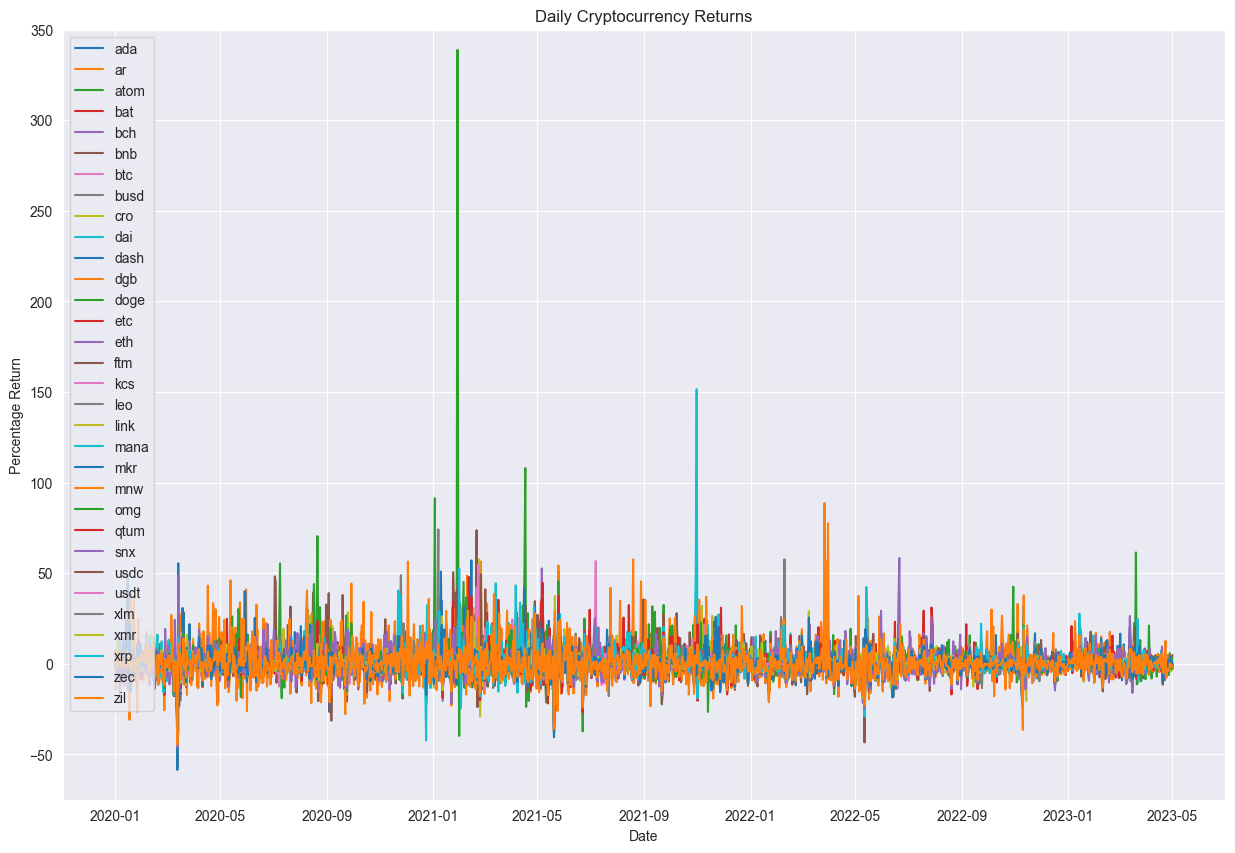

In [206]:
# Plot the returns on the same chart
plt.figure(figsize=(15,10)) # Set the size of the figure
plt.plot(daily_returns*100) # Plot the returns
plt.legend(daily_returns.columns) # Add a legend with the column names as labels
plt.title('Daily Cryptocurrency Returns') # Add a title to the chart
plt.xlabel('Date') # Add a label to the x-axis
plt.ylabel('Percentage Return') # Add a label to the y-axis
plt.ylim(-75, 350) # Adjust the y-axis scale
plt.show() # Show the chart

## Market Condition Classification

Calculate the 10-day rolling standard deviation of the daily returns for each asset (EMA Volatility)

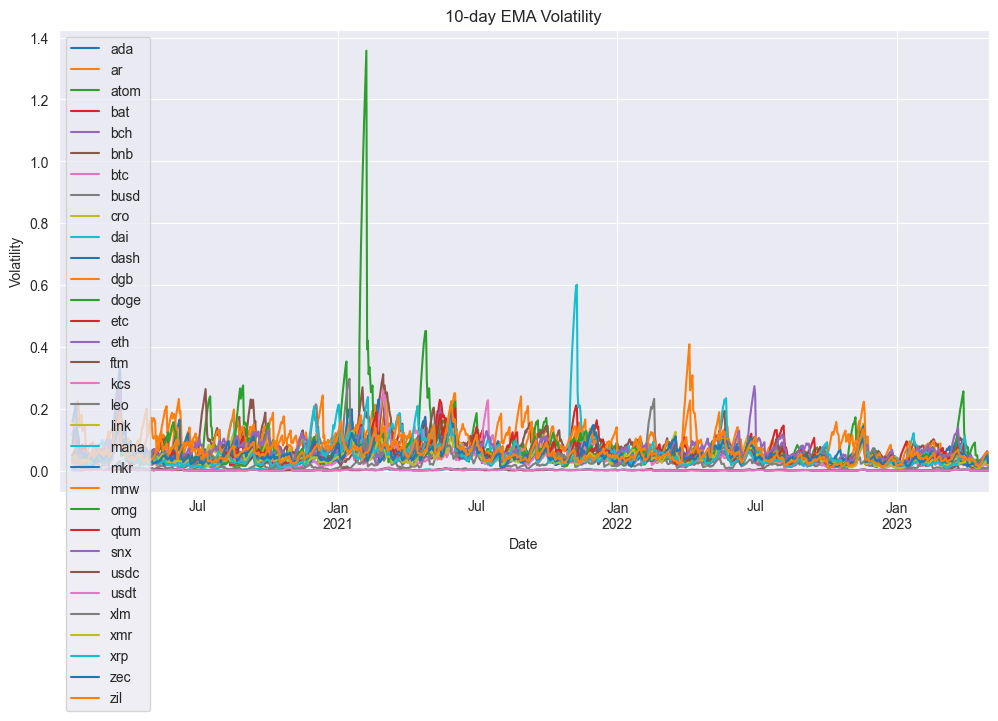

In [207]:
time_window = 10

# Function to Calculate Exponential moving standard deviation
def emsd(data, time_window):
    ema_weights = np.arange(1, time_window + 1)
    ema_weights = ema_weights[::-1]  # Reverse the array
    ema_weights = ema_weights / ema_weights.sum()  # Normalize the weights

    squared_diff = (data - data.rolling(window=time_window).mean()) ** 2
    emsd_values = squared_diff.rolling(window=time_window).apply(lambda x: np.sum(ema_weights * x))

    return np.sqrt(emsd_values)

# Function to plot the EMA Volatility
def plot_emsd(ema_volatility):

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the EMA Volatility for each asset
    for column in ema_volatility.columns:
        ema_volatility[column].plot(ax=ax, label=column)

    # Add labels and a legend
    ax.set_title(f'10-day EMA Volatility')
    ax.set_xlabel('Date')
    ax.set_ylabel('Volatility')
    ax.legend(loc='upper left')

    # Show the plot
    plt.show()

# Calculate the EMA volatility
ema_volatility = emsd(daily_returns, time_window)

# Plot the EMA volatility
plot_emsd(ema_volatility)

Calculate the average EMA volatility for each day across all cryptocurrencies and establish thresholds using standard deviation bands

In [166]:
# # Calculate the average EMA volatility for each day across all cryptocurrencies
# ema_volatility['average_volatility'] = ema_volatility.mean(axis=1)
#
# # Create a new DataFrame to store the aggregated EMA volatility
# agg_ema_volatility = ema_volatility[['average_volatility']]
agg_ema_volatility = pd.DataFrame()
agg_ema_volatility['average_volatility'] = ema_volatility.mean(axis=1)

# Establish thresholds using standard deviation bands
mean_volatility = np.mean(agg_ema_volatility['average_volatility'])
std_volatility = np.std(agg_ema_volatility['average_volatility'])
low_volatility_threshold = mean_volatility - std_volatility
high_volatility_threshold = mean_volatility + std_volatility

Classify the market conditions

In [167]:
# Classify the market conditions
def classify_market_condition(volatility, low_threshold, high_threshold):
    low_threshold_arr = np.full_like(volatility, low_threshold, dtype=float)
    high_threshold_arr = np.full_like(volatility, high_threshold, dtype=float)

    conditions = np.full_like(volatility, "medium_volatility", dtype=object)
    conditions[volatility < low_threshold_arr] = "low_volatility"
    conditions[volatility > high_threshold_arr] = "high_volatility"
    return conditions

market_conditions = classify_market_condition(
    agg_ema_volatility['average_volatility'].values,
    low_volatility_threshold,
    high_volatility_threshold
)

agg_ema_volatility.loc[:, 'market_condition'] = market_conditions
agg_ema_volatility = agg_ema_volatility.dropna()

Plot the market volatility with the market conditions colour coded

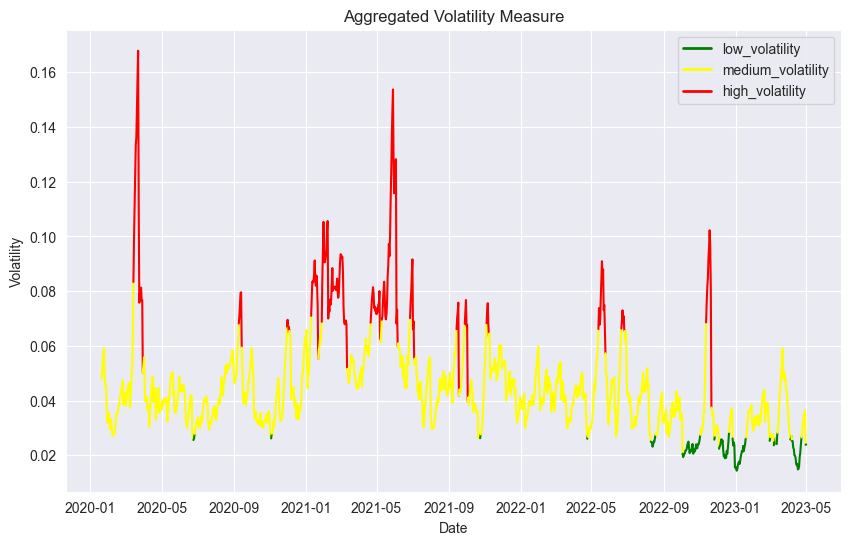

In [168]:
# plot market volatility colour coded
def plot_market_volatility(dates, ema_volatility, market_conditions):
    # Define color mapping for market conditions
    color_map = {'low_volatility': 'green',
                 'medium_volatility': 'yellow',
                 'high_volatility': 'red'}

    plt.figure(figsize=(10, 6))

    prev_index = 0
    prev_condition = market_conditions[0]

    for index, condition in enumerate(market_conditions[1:], 1):
        if condition != prev_condition:
            plt.plot(dates[prev_index:index+1], ema_volatility[prev_index:index+1],
                     color=color_map[prev_condition], label=prev_condition)
            prev_index = index
            prev_condition = condition

    plt.plot(dates[prev_index:], ema_volatility[prev_index:],
             color=color_map[prev_condition], label=prev_condition)

    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title('Aggregated Volatility Measure')
    plt.grid(True)

    # Create custom legend
    custom_lines = [plt.Line2D([0], [0], color=color_map[cond], lw=2) for cond in color_map]
    plt.legend(custom_lines, list(color_map.keys()))

    plt.show()


dates = agg_ema_volatility.index
volatility = agg_ema_volatility['average_volatility']
market_conditions = agg_ema_volatility['market_condition']

# Call the function with data
plot_market_volatility(dates, volatility, market_conditions)

## Correlation Analysis

In [ ]:
# Calculate rolling correlations
window_size = 60
rolling_corr = daily_returns.rolling(window=window_size).corr().dropna()

### Correlation Heatmaps

Calculate the rolling correlation between each cryptocurrency pair and plot the correlation heatmaps with a 6-month interval

In [169]:
# Function to generate heatmap of rolling correlations
def gen_heatmap(data, date):
    correlation_matrix = data.loc[date]
    # Create a correlation heatmap
    plt.figure(figsize=(12, 9))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap for Cryptocurrencies on {date}')
    plt.show()

def gen_heatmap_six_month():
    # Generate heatmaps in 6-month intervals
    date_ranges = pd.date_range(start=daily_returns.index.min() + pd.DateOffset(days=60), end=daily_returns.index.max(), freq='6M')
    for date in date_ranges:
        gen_heatmap(rolling_corr, date.strftime("%Y-%m-%d"))

# gen_heatmap_six_month()

Visualise Correlation During different market conditions

In [170]:
# Getting the dates with high volatility
high_volatility_dates = agg_ema_volatility[agg_ema_volatility['market_condition'] == 'high_volatility'].index

# Getting the dates with medium volatility
medium_volatility_dates = agg_ema_volatility[agg_ema_volatility['market_condition'] == 'medium_volatility'].index

# Getting the dates with low volatility
low_volatility_dates = agg_ema_volatility[agg_ema_volatility['market_condition'] == 'low_volatility'].index


# High volatility correlation heatmaps
def gen_heatmap_high_volatility():
    for date in np.random.choice(high_volatility_dates, size=3, replace=False):
        gen_heatmap(rolling_corr, date.strftime("%Y-%m-%d"))

# gen_heatmap_high_volatility()

In [171]:
def gen_heatmap_medium_volatility():
    # Medium volatility correlation heatmaps
    for date in np.random.choice(medium_volatility_dates, size=3, replace=False):
        gen_heatmap(rolling_corr, date.strftime("%Y-%m-%d"))

# gen_heatmap_medium_volatility()

In [172]:
def gen_heatmap_low_volatility():
    # Low volatility correlation heatmaps
    for date in np.random.choice(low_volatility_dates, size=3, replace=False):
        gen_heatmap(rolling_corr, date.strftime("%Y-%m-%d"))

# gen_heatmap_low_volatility()

Correlation during highest and lowest volatility periods

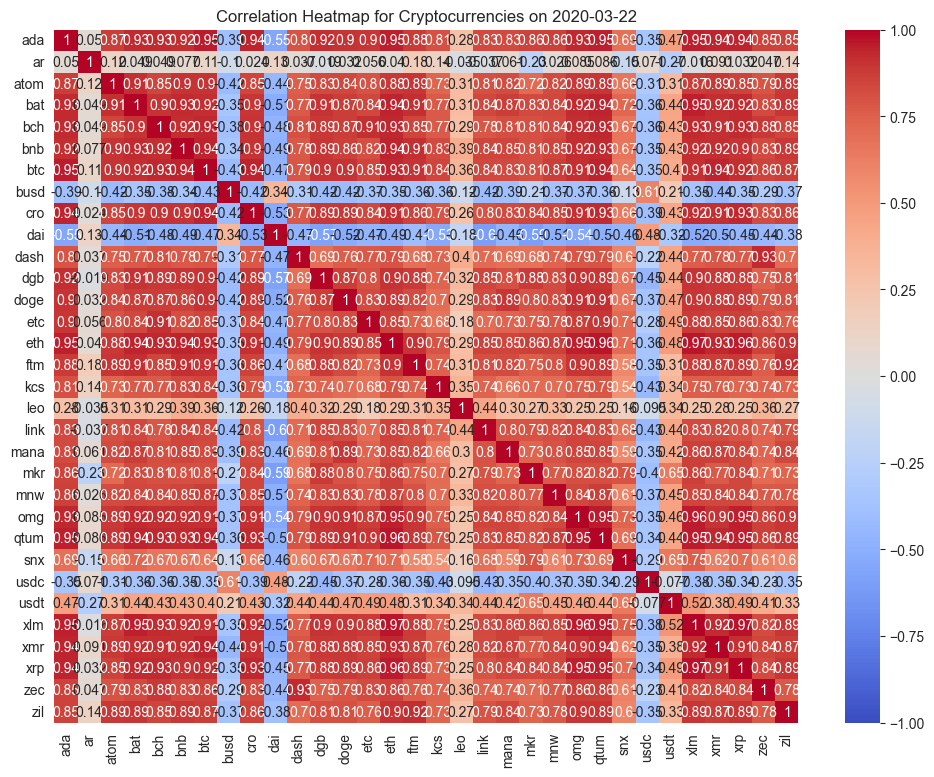

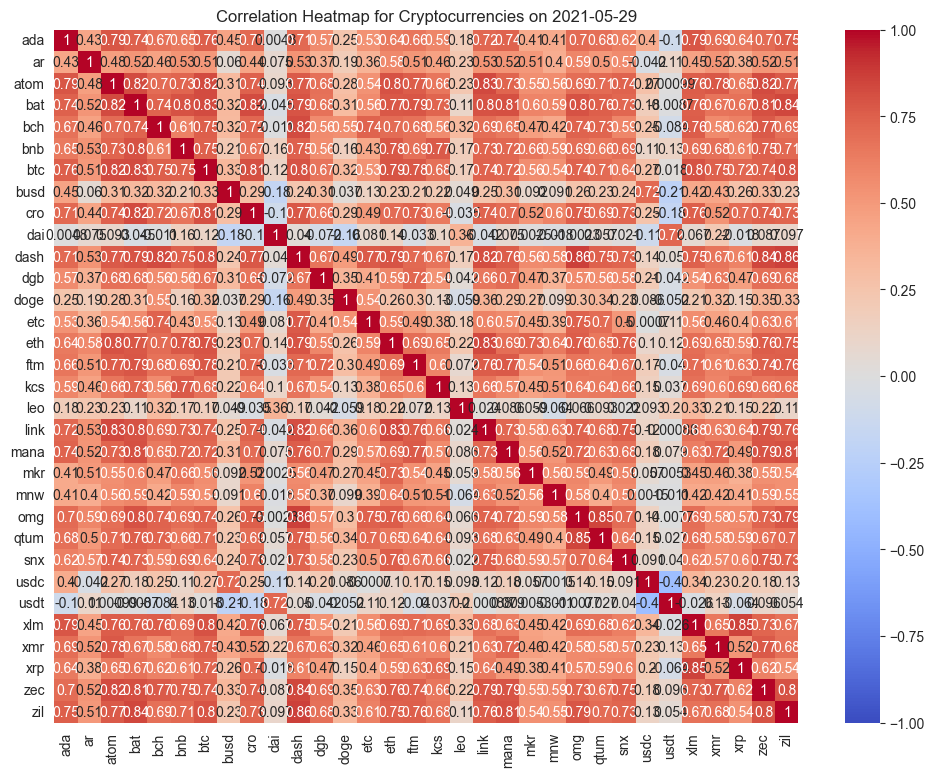

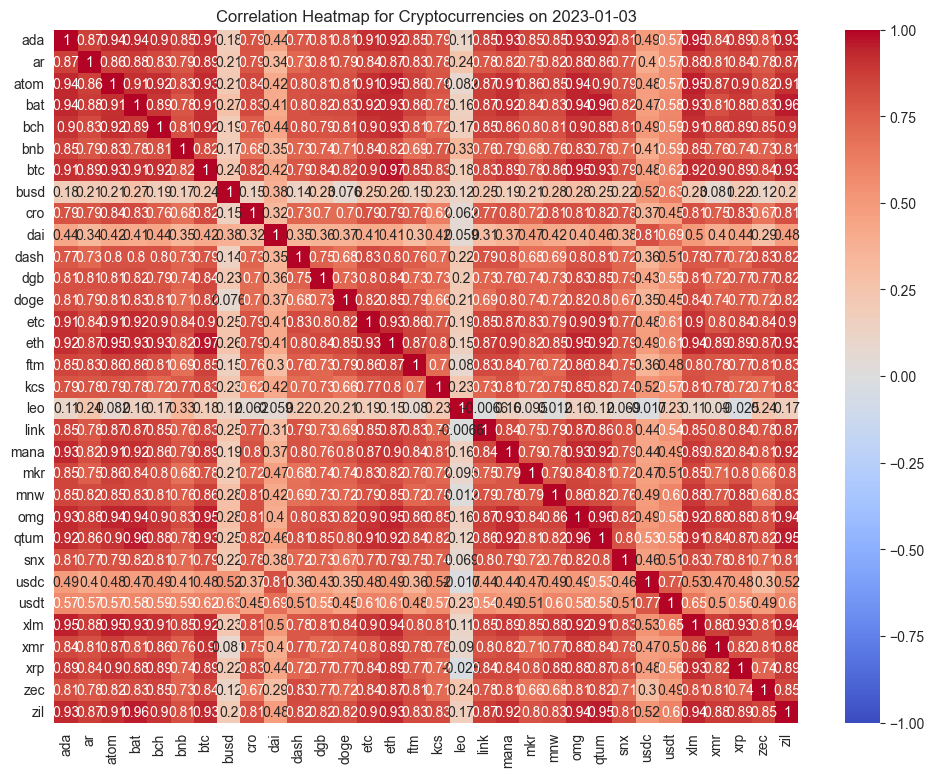

In [173]:
# Find the date with the highest average volatility
max_volatility_date = agg_ema_volatility['average_volatility'].idxmax() # March 22, 2020 Crash

# Find the date with the second peak average volatility
second_peak_volatility_date = agg_ema_volatility.loc['2021']['average_volatility'].idxmax() # May 29, 2021, Crash

# Find the date with the lowest average volatility
min_volatility_date = agg_ema_volatility['average_volatility'].idxmin()


gen_heatmap(rolling_corr, max_volatility_date.strftime("%Y-%m-%d"))
gen_heatmap(rolling_corr, second_peak_volatility_date.strftime("%Y-%m-%d"))
gen_heatmap(rolling_corr, min_volatility_date.strftime("%Y-%m-%d"))

#### Animated Correlation Heatmaps

In [174]:
def create_correlation_matrix_optimized(rolling_correlation):
    # Create a multi-level index DataFrame with snapped_at and level_1 as the index
    rolling_correlation_midx = rolling_correlation.set_index(['snapped_at', 'level_1'])

    # Drop 'snapped_at' and 'level_1' columns and stack the remaining columns
    stacked_rolling_correlation = rolling_correlation_midx.drop(columns=['snapped_at', 'level_1']).stack().reset_index()

    # Rename the columns for clarity
    stacked_rolling_correlation.columns = ['date', 'crypto1', 'crypto2', 'correlation']

    # Create a progress bar
    progress_bar = tqdm(total=len(rolling_correlation), desc='Creating correlation matrix')

    def calculate_correlation(row):
        progress_bar.update(1)
        return row.pivot_table(index=['crypto1', 'date'], columns='crypto2', values='correlation')

    # Create a correlation matrix using pivot_table() with progress bar updates
    correlation_matrix = stacked_rolling_correlation.groupby('date').progress_apply(calculate_correlation)

    progress_bar.close()

    return correlation_matrix

# correlation_matrix_wide = create_correlation_matrix_optimized(rolling_corr)
# correlation_matrix_wide

# # Create a custom animated heatmap using plotly.graph_objects
def create_heatmap(date):
    correlation_data = correlation_matrix_wide.loc[:, date]
    correlation_data_square = correlation_data.pivot_table(index='crypto', columns='level_1', values=0)
    heatmap = go.Heatmap(x=cryptos, y=cryptos, z=correlation_data_square, colorscale='RdBu_r', zmin=-1, zmax=1, showscale=False)
    return heatmap

# # Create a custom animated heatmap using plotly.graph_objects
# fig = go.Figure()
#
# # Get the list of unique dates and cryptocurrencies
# dates = rolling_corr.index.unique()
# cryptos = rolling_corr['level_1'].unique()
#
# # Create a heatmap for each date using parallel processing
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     heatmaps = list(tqdm(executor.map(create_heatmap, dates), total=len(dates)))
#
# # Add heatmaps to the figure
# fig.add_traces(heatmaps)
#
# # Set up the animation settings
# animation_settings = dict(frame=dict(duration=500, redraw=True), fromcurrent=True, showlegend=False)
#
# # Customize the appearance of the heatmap
# fig.update_layout(title='Animated Correlation Heatmap for Cryptocurrencies',
#                   xaxis_title='Crypto1',
#                   yaxis_title='Crypto2',
#                   width=800,
#                   height=800,
#                   updatemenus=[dict(type='buttons', showactive=False, buttons=[dict(label='Play', method='animate', args=[None, animation_settings])])])
#
# # Display the animated heatmap
# fig.show()

print_dataframe_structure(rolling_corr)

Index data type:  object
Column structure:  Index(['ada', 'ar', 'atom', 'bat', 'bch', 'bnb', 'btc', 'busd', 'cro', 'dai',
       'dash', 'dgb', 'doge', 'etc', 'eth', 'ftm', 'kcs', 'leo', 'link',
       'mana', 'mkr', 'mnw', 'omg', 'qtum', 'snx', 'usdc', 'usdt', 'xlm',
       'xmr', 'xrp', 'zec', 'zil'],
      dtype='object')
Shape of the DataFrame:  (37024, 32)
Number of missing values:  0
Dataframe Info: 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 37024 entries, (Timestamp('2020-03-01 00:00:00+0000', tz='UTC'), 'ada') to (Timestamp('2023-05-01 00:00:00+0000', tz='UTC'), 'zil')
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ada     37024 non-null  float64
 1   ar      37024 non-null  float64
 2   atom    37024 non-null  float64
 3   bat     37024 non-null  float64
 4   bch     37024 non-null  float64
 5   bnb     37024 non-null  float64
 6   btc     37024 non-null  float64
 7   busd    37024 non-null  float64
 8  

### Correlation Line Plots

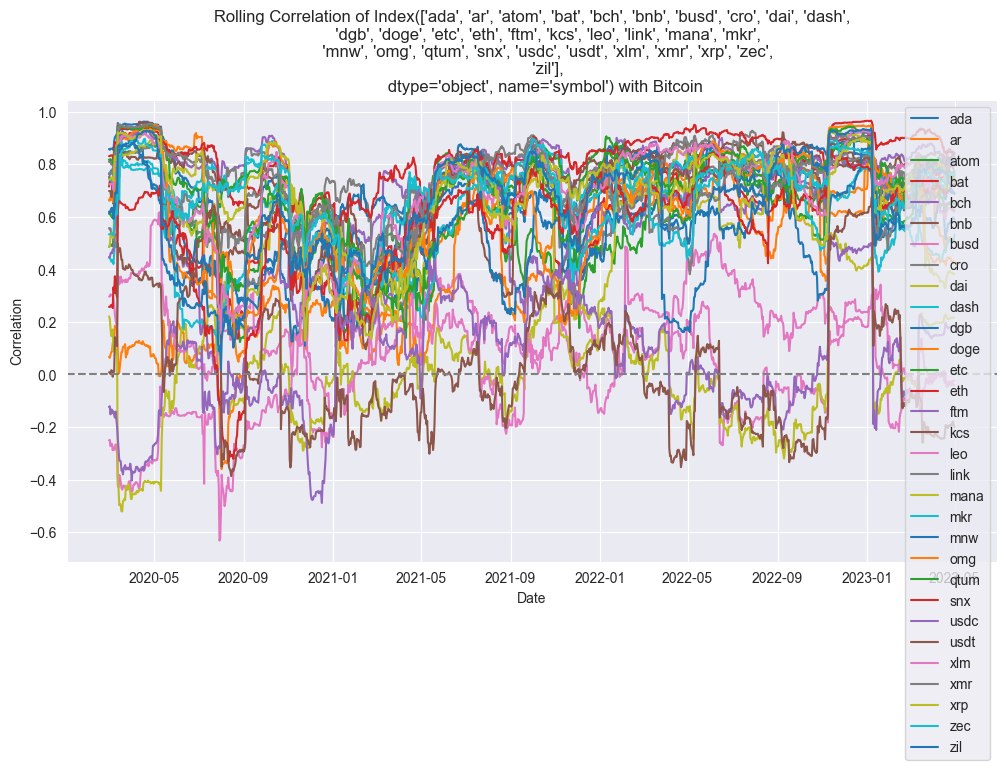

In [175]:
def get_correlation_df(ticker='btc'):
    # Convert the series to a DataFrame
    corr_df = rolling_corr[ticker].reset_index()

    # Rename the columns to be more descriptive
    corr_df.columns = ['snapped_at', 'symbol', 'correlation']

    # Pivot the DataFrame to get the desired format
    pivoted_corr_df = corr_df.pivot(index='snapped_at', columns='symbol', values='correlation')

    # Drop the ticker itself from the columns
    pivoted_corr_df.drop(ticker, axis=1, inplace=True)
    return pivoted_corr_df


btc_corr = get_correlation_df('btc')


def plot_correlation_line(dataframe, symbol):
    # Filter the DataFrame to get the data for the given symbol
    corr_data = dataframe[symbol]

    # Plot the correlation data
    plt.figure(figsize=(12, 6))
    plt.plot(corr_data, label=symbol)
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.title(f'Rolling Correlation of {symbol} with Bitcoin')
    # Add a horizontal line at y=0
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()
    plt.show()

# Call the function with the pivoted_corr_df DataFrame and the symbol you want to plot
plot_correlation_line(btc_corr, btc_corr.columns)

## Portfolio Construction -  Modern Portfolio Theory (MPT)

#### Compute the rolling covariance matrix from the rolling correlation and EMA volatility

In [178]:
def compute_covariance_matrix(rolling_corr, ema_volatility):
    # create empty DataFrame with the same index and columns as rolling_corr
    rolling_cov = pd.DataFrame(index=rolling_corr.index, columns=rolling_corr.columns)

    # loop over each period
    for date, asset in tqdm(rolling_corr.index):
        # for each asset, calculate covariance with all other assets
        for other_asset in rolling_corr.columns:
            rolling_cov.loc[(date, asset), other_asset] = rolling_corr.loc[(date, asset), other_asset] * ema_volatility.loc[date, asset] * ema_volatility.loc[date, other_asset]

    return rolling_cov

# rolling_cov = compute_covariance_matrix(rolling_corr, ema_volatility)

100%|██████████| 37024/37024 [04:07<00:00, 149.75it/s]


Save the covariance matrix to a pickle file

In [180]:
# Save the covariance matrix to a pickle file
def save_covariance_matrix(rolling_cov):
    rolling_cov.to_pickle('rolling_cov.pkl')

# save_covariance_matrix(rolling_cov)

Load the covariance matrix from the pickle file

In [ ]:
# Load the covariance matrix from the pickle file
rolling_cov = pd.read_pickle('rolling_cov.pkl')

#### Model setup

Define Expected Returns, Objective Function and Constraints

In [181]:
expected_returns = daily_returns.mean()

# Define the objective function - minimize portfolio volatility (stabdard deviation)
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)

# Define the constraint for the target return
def target_return_constraint(weights, target_return, expected_returns):
    return expected_returns @ weights - target_return
    # ensures the expected return of the portfolio, given the asset weights, equals the target return


Functions to generate portfolios for a range of target returns, and to plot the efficient frontier

In [269]:
# Function to generate portfolios for a range of target returns
def generate_portfolios(returns, cov_matrix, target_returns):

    # Set the bounds and initial guess for the asset weights
    bounds = [(0,1) for _ in range(len(returns.columns))]
    init_guess = np.repeat(1/len(returns.columns), len(returns.columns))

    # Initialize lists to store the results
    portfolio_weights = []
    portfolio_returns = []
    portfolio_volatilities = []

    # Loop over the target returns
    for target_return in tqdm(target_returns):
        # Set the constraint for the sum of weights and target return
        cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                {'type': 'eq', 'fun': lambda x: target_return_constraint(x, target_return, returns.mean())}]

        # Optimize weights to minimize volatility for the given target return
        result = minimize(portfolio_volatility, init_guess, args=(cov_matrix,), method='SLSQP', constraints=cons, bounds=bounds)

        # Append the results to the lists
        portfolio_weights.append(result.x)
        portfolio_returns.append(target_return)
        portfolio_volatilities.append(result.fun)

    return portfolio_weights, portfolio_returns, portfolio_volatilities


# Function to plot the efficient frontier
def plot_efficient_frontier(portfolio_volatilities, portfolio_returns, portfolio_sharpe_ratios):
    # Identify the portfolio with the highest Sharpe ratio
    max_index = np.argmax(portfolio_sharpe_ratios)
    max_sharpe_portfolio = portfolio_returns[max_index], portfolio_volatilities[max_index]

    plt.figure(figsize=(10,6))
    plt.scatter(portfolio_volatilities, portfolio_returns, c=portfolio_sharpe_ratios, cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Returns')
    plt.title('Efficient Frontier with Dynamic Risk-Free Rate')
    # Plot the portfolio with the highest Sharpe ratio
    plt.scatter(max_sharpe_portfolio[1], max_sharpe_portfolio[0], marker='*', color='r', s=200, label='Max Sharpe Ratio')
    plt.legend()
    plt.show()

Run the functions to generate portfolios and plot the efficient frontier

In [247]:
average_cov_matrix = rolling_cov.groupby(level=1).mean()

# generate a range of target returns, with as many points as there are days in 'daily_returns', between the minimum and the maximum of  daily expected returns.
target_returns = np.linspace(expected_returns.min(), expected_returns.max(), len(daily_returns))

# portfolio_weights, portfolio_returns, portfolio_volatilities = generate_portfolios(daily_returns, average_cov_matrix, target_returns)
#
# # Save data
# save_data(portfolio_weights, 'portfolio_weights.pkl')
# save_data(portfolio_returns, 'portfolio_returns.pkl')
# save_data(portfolio_volatilities, 'portfolio_volatilities.pkl')


100%|██████████| 1216/1216 [24:18<00:00,  1.20s/it]


In [275]:
# Load data
portfolio_weights = load_data('portfolio_weights.pkl')
portfolio_returns = load_data('portfolio_returns.pkl')
portfolio_volatilities = load_data('portfolio_volatilities.pkl')

Calculate the Sharpe ratio for each portfolio

In [277]:
risk_free_rates = merged_ust_data.loc[daily_returns.index, '52 WEEKS BANK DISCOUNT']
excess_returns = np.array(portfolio_returns) - risk_free_rates.values
portfolio_sharpe_ratios = excess_returns / np.array(portfolio_volatilities)

Plot the efficient frontier

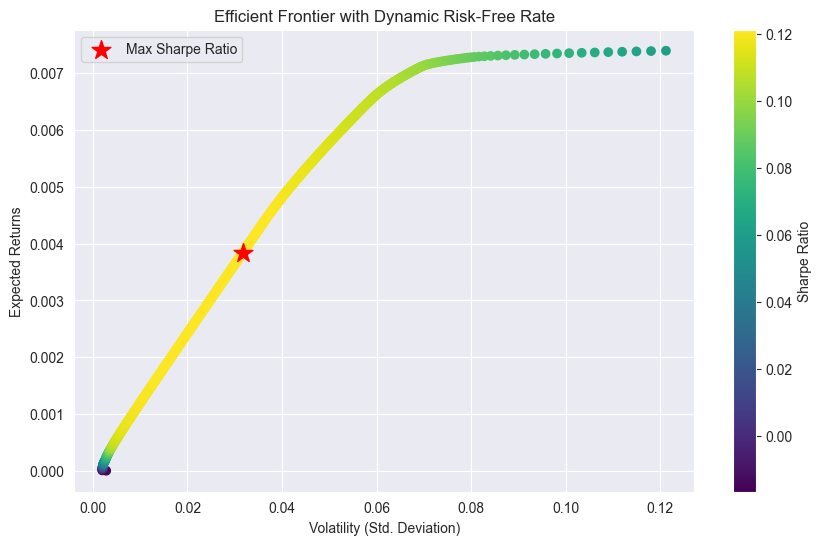

In [276]:
plot_efficient_frontier(portfolio_volatilities, portfolio_returns, portfolio_sharpe_ratios)

Efficient frontier shows the optimal portfolios that provide the best possible expected return for the given level of risk (volatility). Portfolios are constructed by calculating the optimal static weights for each asset in the portfolio to minimize the volatility for a given target return. The target returns are varied to generate the efficient frontier. Expected returns are returns based on past performance. The plot also shows the sharpe ratio for each portfolio. Higher Sharpe ratio means higher risk adjusted returns. The optimal portfolio is the one that provides the highest Sharpe ratio.

#### Visualise the optimal portfolio

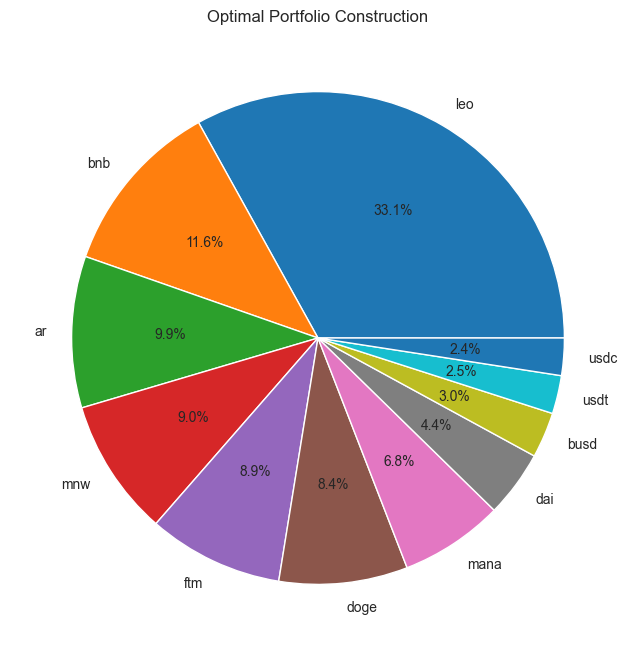

   Cryptocurrency Weight
0             leo  33.1%
1             bnb  11.6%
2              ar   9.9%
3             mnw   9.0%
4             ftm   8.9%
5            doge   8.4%
6            mana   6.8%
7             dai   4.4%
8            busd   3.0%
9            usdt   2.5%
10           usdc   2.4%


In [285]:
# Identify the portfolio with the highest Sharpe ratio
max_index = np.argmax(portfolio_sharpe_ratios)
optimal_portfolio_weights = portfolio_weights[max_index]

# Convert the weights to a pandas Series
weights_series = pd.Series(optimal_portfolio_weights, index=daily_returns.columns)

# Filter out the cryptocurrencies with 0% weight
weights_series = weights_series[weights_series > 0.0001]

# sort the cryptocurrencies by weight in descending order
weights_series = weights_series.sort_values(ascending=False)

def plot_optimal_portfolio_pir():
    # Create a pie chart
    plt.figure(figsize=(10, 8))
    weights_series.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Optimal Portfolio Construction')
    plt.ylabel('')  # This removes the default 'None' ylabel
    plt.show()

# Create a table
weights_df = weights_series.reset_index()
weights_df.columns = ['Cryptocurrency', 'Weight']

# Convert the weights to percentages rounded to 1 decimal place
weights_df['Weight'] = weights_df['Weight'].apply(lambda x: f'{x*100:.1f}%')

print(weights_df)

In [236]:
print_dataframe_structure(daily_returns)

Index data type:  datetime64[ns, UTC]
Column structure:  Index(['ada', 'ar', 'atom', 'bat', 'bch', 'bnb', 'btc', 'busd', 'cro', 'dai',
       'dash', 'dgb', 'doge', 'etc', 'eth', 'ftm', 'kcs', 'leo', 'link',
       'mana', 'mkr', 'mnw', 'omg', 'qtum', 'snx', 'usdc', 'usdt', 'xlm',
       'xmr', 'xrp', 'zec', 'zil'],
      dtype='object')
Shape of the DataFrame:  (1216, 32)
Number of missing values:  0
Dataframe Info: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1216 entries, 2020-01-02 00:00:00+00:00 to 2023-05-01 00:00:00+00:00
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ada     1216 non-null   float64
 1   ar      1216 non-null   float64
 2   atom    1216 non-null   float64
 3   bat     1216 non-null   float64
 4   bch     1216 non-null   float64
 5   bnb     1216 non-null   float64
 6   btc     1216 non-null   float64
 7   busd    1216 non-null   float64
 8   cro     1216 non-null   float64
 9   dai     12